In [5]:
import pandas as pd 
import tensorflow as tf 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model 
from sklearn.metrics import precision_recall_fscore_support 
import matplotlib.pyplot as plt

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [12]:
data.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [29]:
overall_data = pd.read_excel('tfcu_member.xlsx', index_col=0, sheet_name='KPI Data')
df_ = overall_data.drop(overall_data.index[0:3])
df = df_.drop(columns=['Unnamed: 10'])
df_time = df[['Week','Member Retention',
       'Employee Retention', 'Member Satisfaction NPS', 'Fraud rate',
       'Employee satisfaction', 'Number of Employee Relations Issues',
       '# of Member complaints', 'Member acquisition cost (CAC)',
       'Number of Compliance Issues', 'Compliance Investigation Cycle Time',
       'Decline rate', 'Financial impact due to attacks',
       'Attempted vs Fraudulent Transactions', 'Final Approval rate',
       'Fraudulent Vs Declined Transactions', 'System Uptime',
       'Severity of attacks', 'Mean Time Between Failures (MTBF)',
       'Cost per incident', 'Number of cybersecurity incidents reported'
             ]].groupby(['Week']).mean()
df_anomaly =  pd.DataFrame(df_time['Member Satisfaction NPS'], columns=['Member Satisfaction NPS'])

In [31]:
import pandas as pd
# data = pd.read_csv( 
#     'https://raw.githubusercontent.com/numenta'
#     '/NAB/master/data/realKnownCause/ambient'
#     '_temperature_system_failure.csv') 


data = df_anomaly
# Exclude datetime column 
# data_values = data.drop('timestamp', 
#                         axis=1).values 
data_values = data.values 
  
# Convert data to float type 
data_values = data_values.astype('float32') 
  
# Create new dataframe with converted values 
data_converted = pd.DataFrame(data_values, 
                              columns=data.columns) 
  
# Add back datetime column 
data_converted.insert(0, 'timestamp', 
                      df_anomaly.index) 

In [32]:
data_converted = data_converted.dropna() 
data_tensor = tf.convert_to_tensor(data_converted.drop( 
    'timestamp', axis=1).values, dtype=tf.float32) 
  
# Define the autoencoder model 
input_dim = data_converted.shape[1] - 1
encoding_dim = 10
  
input_layer = Input(shape=(input_dim,)) 
encoder = Dense(encoding_dim, activation='relu')(input_layer) 
decoder = Dense(input_dim, activation='relu')(encoder) 
autoencoder = Model(inputs=input_layer, outputs=decoder) 
  
# Compile and fit the model 
autoencoder.compile(optimizer='adam', loss='mse') 
autoencoder.fit(data_tensor, data_tensor, epochs=50, 
                batch_size=32, shuffle=True) 
  
# Calculate the reconstruction error for each data point 
reconstructions = autoencoder.predict(data_tensor) 
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions), 
                     axis=1) 
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores') 
anomaly_scores.index = data_converted.index 

Epoch 1/50
2/2 [==============================] - 0s 2ms/step - loss: 5.4631
Epoch 2/50
2/2 [==============================] - 0s 1ms/step - loss: 3.2057
Epoch 3/50
2/2 [==============================] - 0s 2ms/step - loss: 1.5701
Epoch 4/50
2/2 [==============================] - 0s 2ms/step - loss: 0.5504
Epoch 5/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0799
Epoch 6/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0268
Epoch 7/50
2/2 [==============================] - 0s 2ms/step - loss: 0.2026
Epoch 8/50
2/2 [==============================] - 0s 2ms/step - loss: 0.4148
Epoch 9/50
2/2 [==============================] - 0s 2ms/step - loss: 0.5320
Epoch 10/50
2/2 [==============================] - 0s 2ms/step - loss: 0.5141
Epoch 11/50
2/2 [==============================] - 0s 2ms/step - loss: 0.3935
Epoch 12/50
2/2 [==============================] - 0s 1ms/step - loss: 0.2346
Epoch 13/50
2/2 [==============================] - 0s 2ms/step - loss: 0.

In [44]:
threshold = anomaly_scores.quantile(0.9) 
anomalous = anomaly_scores > threshold 
binary_labels = anomalous.astype(int) 
precision, recall, f1_score, _ = precision_recall_fscore_support( 
        binary_labels, anomalous, average='binary') 

In [45]:
# anomalous_2 = anomaly_scores < -threshold
# anomalous_2

In [36]:

test = data_converted['Member Satisfaction NPS'].values 
predictions = anomaly_scores.values 
  
print("Precision: ", precision) 
print("Recall: ", recall) 
print("F1 Score: ", f1_score) 

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


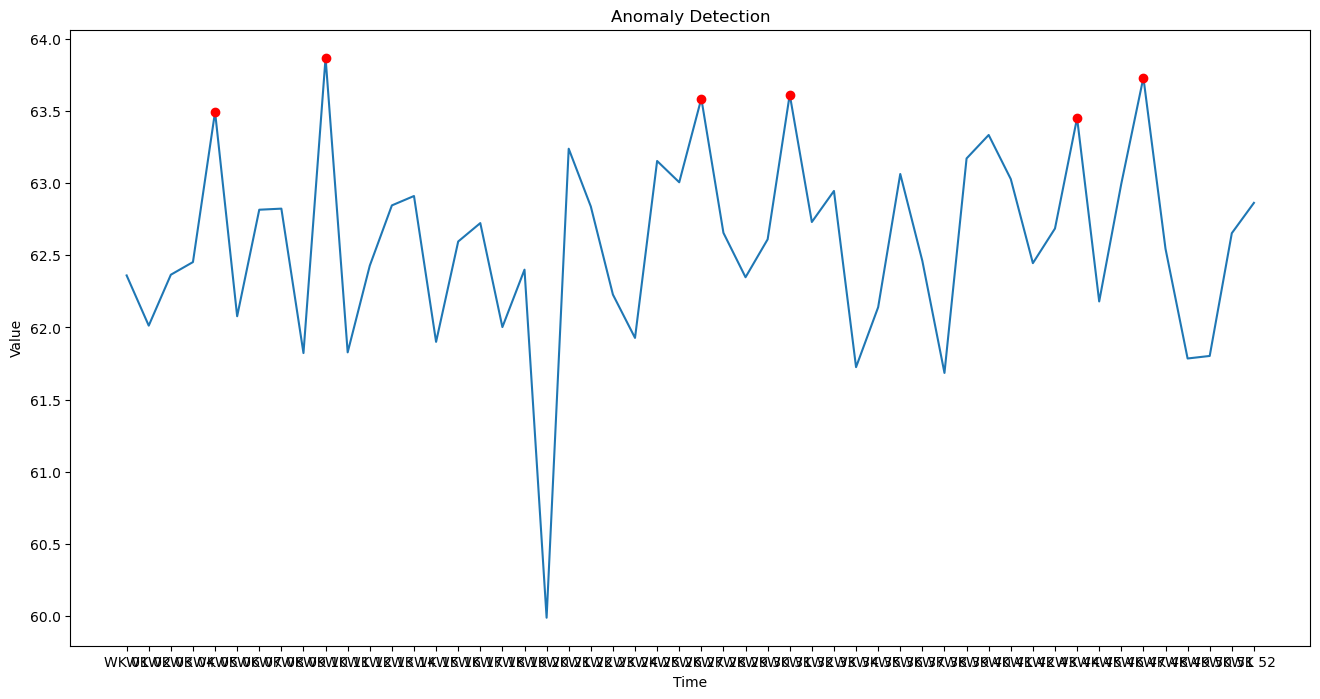

In [46]:

# Plot the data with anomalies marked in red 
plt.figure(figsize=(16, 8)) 
plt.plot(data_converted['timestamp'], 
         data_converted['Member Satisfaction NPS']) 
plt.plot(data_converted['timestamp'][anomalous], 
         data_converted['Member Satisfaction NPS'][anomalous], 'ro') 
plt.title('Anomaly Detection') 
plt.xlabel('Time') 
plt.ylabel('Value') 
plt.show() 